## WORK IN PROGRESS:

The following is a project inspired by work performed 2020-2021 in the Data Science For All program, hosted by Correlation One. The following is a recreation and extension of the original analysis.

https://github.com/OpportunityInsights/EconomicTracker/blob/main/docs/oi_tracker_data_dictionary.md
https://github.com/OpportunityInsights/EconomicTracker/tree/main/data
https://github.com/OpportunityInsights/EconomicTracker/blob/main/docs/oi_tracker_data_documentation.md


# Set up environment
Declare functions and import library

In [1]:
#import libraries
import pandas as pd
import numpy as np
import requests
import io
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
import math

from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import datetime as dt

%matplotlib inline

In [2]:
## DATA CLEANING FUNCTION STORAGE
def add_state_col(df, stateID_df):
  #extract and transform vector of state ID for each column
  state_id_by_day = list(df['statefips'].array)
  state_list_comp_df = [(state_IDs['statename'][state_IDs['statefips'] == key].array[0]) for index,key in enumerate(state_id_by_day)]
  df['state']= state_list_comp_df

def slice_dict(input_dict, start_indx, end_indx):
  dict_slice = [input_dict[key] for key in list(input_dict.keys())[start_indx:end_indx]]
  return dict_slice

  ## DATA CLEANING FUNCTIONS
def replace_nonnumeric_entries_df_force_nan(test_df, protected_cols):
  mutable_cols = [i for i in test_df.columns.array if i not in protected_cols]
  for index, col in enumerate(test_df.loc[:,mutable_cols].columns):
    test_df.loc[:,col] = pd.to_numeric(test_df.loc[:,col], errors = 'coerce') #force column to become numeric, returning nan if not 
  test_df = test_df.fillna(value = 0) #fill any NA values with 0 
  return test_df

def convert_obj_col_to_numeric(df): #, new_type):
  for col in df.columns:
    if df[col].dtype == object:
      df[col] = df[col].apply(pd.to_numeric, errors = 'coerce') #stack overflow version
      #original version: df[col] = df[col].astype(new_type)
      #print(df[col].dtype) #for DEBUG
  return df

In [3]:
#set what plot type to use 
#https://matplotlib.org/stable/gallery/style_sheets/style_sheets_reference.html
plt.style.use('seaborn-deep')

# Import Data and evaluate format

In [4]:
#Declare URL for important opportunity tracker data 
raw_covid_rate_by_state_url = 'https://raw.githubusercontent.com/OpportunityInsights/EconomicTracker/main/data/COVID%20-%20State%20-%20Daily.csv' #current to 2022-01-31
state_IDs_url = 'https://raw.githubusercontent.com/OpportunityInsights/EconomicTracker/main/data/GeoIDs%20-%20State.csv' #IDs used for each state in later tables
spending_by_state_url = 'https://raw.githubusercontent.com/OpportunityInsights/EconomicTracker/main/data/Affinity%20-%20State%20-%20Daily.csv' #affinity is personal spending #ends 2021-11-24
revenue_by_state_url = 'https://raw.githubusercontent.com/OpportunityInsights/EconomicTracker/main/data/Womply%20-%20State%20-%20Daily.csv' #womply is small busines revenue #ends 2021-07-09

In [5]:
#import OT data
covid_rate_per_state = pd.read_csv(raw_covid_rate_by_state_url, dtype = 'str')
state_IDs = pd.read_csv(state_IDs_url, dtype = 'str')
spending_per_state = pd.read_csv(spending_by_state_url, dtype = 'str')
revenue_per_state = = pd.read_csv(revenue_by_state_url, dtype = 'str')

Do a preliminary check on the data, inspect it for inconsistencies/mission data:

In [6]:
spending_per_state.head(1).append(spending_per_state.tail(1))

,year,month,day,statefips,freq,spend_all,spend_aap,spend_acf,spend_aer,spend_apg,spend_durables,spend_nondurables,spend_grf,spend_gen,spend_hic,spend_hcs,spend_inpersonmisc,spend_remoteservices,spend_sgh,spend_tws,spend_retail_w_grocery,spend_retail_no_grocery,spend_all_incmiddle,spend_all_q1,spend_all_q2,spend_all_q3,spend_all_q4,provisional
0,2020,1,1,1,d,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,.,0
34577,2021,11,14,56,w,.212,.149,.,.2,.508,.304,.202,.0895,.92,.294,.,.234,.174,.567,.2,.247,.344,.194,.19,.236,.162,.304,1


In [7]:
covid_rate_per_state.head(1).append(covid_rate_per_state.tail(1))

,year,month,day,statefips,new_case_count,new_death_count,case_count,death_count,vaccine_count,fullvaccine_count,booster_first_count,new_vaccine_count,new_fullvaccine_count,new_booster_first_count,new_test_count,test_count,hospitalized_count,new_case_rate,case_rate,new_death_rate,death_rate,new_test_rate,test_rate,new_vaccine_rate,vaccine_rate,new_fullvaccine_rate,fullvaccine_rate,new_booster_first_rate,booster_first_rate,hospitalized_rate
0,2020,1,7,15,.,.,.,.,.,.,.,.,.,.,.,.,0,.,.,.,.,.,.,.,.,.,.,.,.,0
37874,2022,1,30,56,1308,3,142162,1622,331208,288323,116078,262,180,438,3505,1296780,161,226,24563,.592,280,606,224062,.0452,57.2,.031,49.8,.0757,20.1,27.8


In [8]:
state_IDs.tail(1)

,statefips,statename,stateabbrev,state_pop2019
50,56,Wyoming,WY,578759


Looks like the start of both covid_rate_per_state and econ_per_state have missing values, presumably from the fact that they are from periods before COVID-19 was detected/known about. I thus in the next section clean that data.

# Data cleaning:
> Removed non numeric values programmatically from DFs of interest



In [9]:
protected_cols = list(covid_rate_per_state.keys())[0:4] + ['state']
#add which state each row is taken from
add_state_col(spending_per_state, state_IDs)
add_state_col(covid_rate_per_state, state_IDs)

spending_per_state= replace_nonnumeric_entries_df_force_nan(spending_per_state, protected_cols)
covid_rate_per_state = replace_nonnumeric_entries_df_force_nan(covid_rate_per_state, protected_cols)

In [10]:
spending_per_state.head(1).append(spending_per_state.tail(1))

,year,month,day,statefips,freq,spend_all,spend_aap,spend_acf,spend_aer,spend_apg,spend_durables,spend_nondurables,spend_grf,spend_gen,spend_hic,spend_hcs,spend_inpersonmisc,spend_remoteservices,spend_sgh,spend_tws,spend_retail_w_grocery,spend_retail_no_grocery,spend_all_incmiddle,spend_all_q1,spend_all_q2,spend_all_q3,spend_all_q4,provisional,state
0,2020,1,1,1,0.0,0.000,0.000,0.0,0.0,0.000,0.000,0.000,0.0000,0.00,0.000,0.0,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.00,0.000,0.000,0.000,0,Alabama
34577,2021,11,14,56,0.0,0.212,0.149,0.0,0.2,0.508,0.304,0.202,0.0895,0.92,0.294,0.0,0.234,0.174,0.567,0.2,0.247,0.344,0.194,0.19,0.236,0.162,0.304,1,Wyoming


In [11]:
covid_rate_per_state.head(1).append(covid_rate_per_state.tail(1))

,year,month,day,statefips,new_case_count,new_death_count,case_count,death_count,vaccine_count,fullvaccine_count,booster_first_count,new_vaccine_count,new_fullvaccine_count,new_booster_first_count,new_test_count,test_count,hospitalized_count,new_case_rate,case_rate,new_death_rate,death_rate,new_test_rate,test_rate,new_vaccine_rate,vaccine_rate,new_fullvaccine_rate,fullvaccine_rate,new_booster_first_rate,booster_first_rate,hospitalized_rate,state
0,2020,1,7,15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0000,0.0,0.000,0.0,0.0000,0.0,0.0,Hawaii
37874,2022,1,30,56,1308.0,3.0,142162.0,1622.0,331208.0,288323.0,116078.0,262.0,180.0,438.0,3505.0,1296780.0,161.0,226.0,24563.0,0.592,280.0,606.0,224062.0,0.0452,57.2,0.031,49.8,0.0757,20.1,27.8,Wyoming


Manual inspection of data shows that cleaning has been successful. I thus continue to perform preliminary EDA

In [12]:
cali_covid_case_rate = covid_rate_per_state.loc[covid_rate_per_state.loc[:, 'state']== 'California', 'new_case_rate'].copy().reset_index(drop = True)
cali_spending = spending_per_state.loc[spending_per_state['state']== 'California', :].copy().reset_index(drop = True)

In [14]:
cols_of_interest = dict() #create dict where key is information type, and value is the list of columns to use that aren't indexs
#store covid columns of interest 
cols_of_interest['covid'] = [j for j in list(covid_rate_per_state.columns) if j not in protected_cols] #store covid columns of interest 
cols_of_interest['spending'] =[i for i in list(spending_per_state.columns) if i not in protected_cols] #store spendingcolumns of interest

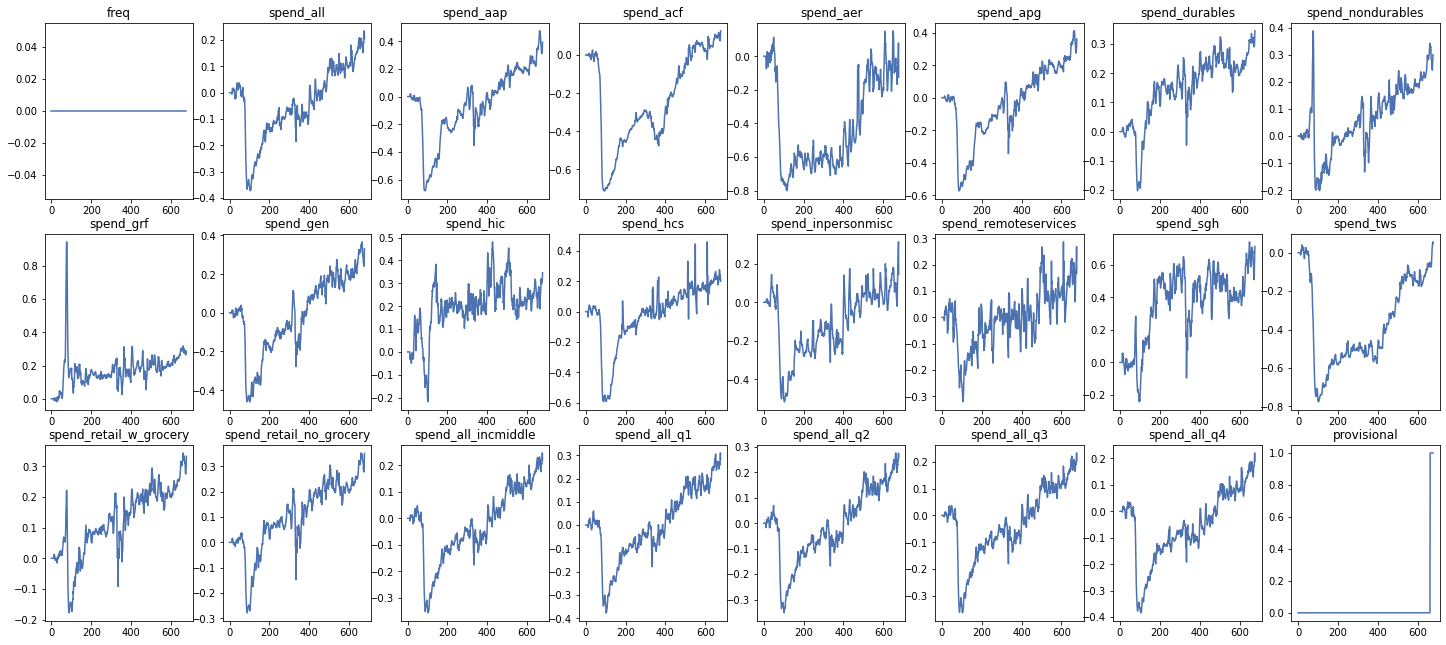

In [15]:
metric = 'spending'
num_subplots = len(cols_of_interest[metric])
num_rows = 3
num_cols = math.ceil(num_subplots/num_rows)

fg, axs = plt.subplots(ncols = num_cols, nrows = num_rows, figsize = (25,11))
i = 0
for row in range(num_rows):
  for col in range(num_cols):
    axs[row,col].set_title(cols_of_interest[metric][i]);
    axs[row, col].plot(cali_spending.loc[:,cols_of_interest[metric][i]]);
    i = i+1 #counter to iter throuhg colums of interest


## WORK IN PROGRESS- Building Ordinary Least Squares Linear Regression


In [31]:
def prepare_data_linReg(covid,revenue):

  df_lengths = sorted([len(covid), len(spending)]) #find which df is shorter 
  truncate_len = df_lengths[0]-1 
  Y_var = np.array(revenue.loc[:truncate_len,'spend_all'].copy())
  #import X variables 
  indep_vars = ['new_death_rate','new_case_rate']#, 'spend_all'] #can choose other independent variables of interest using the heatmap plot above 
  X_array = np.array(covid.loc[:truncate_len,indep_vars].copy()) #rows are days, columns are features
  return X_array, Y_var

In [37]:

def plot_linear_regression_on_state(Y_prediction, Y_var, state):
#INPUT: COVID is slice df of renue
  #revenue is econ info over time
  #revenue = create_rev_df(stateID_df, stateSBrevenue_df, state)
  #train on X and then test
  plt.figure(figsize=(18,18));
  fig, ax = plt.subplots();
  ax.plot(Y_prediction, color = 'r', label = 'Predicted SB Revenue');
  #plot with dates
  #ax.plot_date(mp_dates, Y_prediction, xdate = True, color = 'r', label = 'Predicted SB Revenue');
  ax.plot(Y_var, label = 'Real SB Revenue');
  plt.legend();
  plt.title(state + ' Linear Regression: Predict SB Revenue with covid spread. R^2 = ' + str(round(reg.score(X_array,Y_var), 2)));
  plt.xlabel('Days since National Emergency Declared');
  plt.ylabel(' Proportional Change in SB Revenue');
  return fig, ax


In [22]:
#RUN LINEAR REGRESSION ON STATES
covid = covid_rate_per_state.loc[covid_rate_per_state.loc[:, 'state']== 'California', :].copy().reset_index(drop = True)
spending = spending_per_state.loc[spending_per_state['state']== 'California', :].copy().reset_index(drop = True)

,year,month,day,statefips,new_case_count,new_death_count,case_count,death_count,vaccine_count,fullvaccine_count,booster_first_count,new_vaccine_count,new_fullvaccine_count,new_booster_first_count,new_test_count,test_count,hospitalized_count,new_case_rate,case_rate,new_death_rate,death_rate,new_test_rate,test_rate,new_vaccine_rate,vaccine_rate,new_fullvaccine_rate,fullvaccine_rate,new_booster_first_rate,booster_first_rate,hospitalized_rate,state
0,2020,1,21,6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.000,0.0,0.0000,0.0,0.000,0.0,0.0,California
740,2022,1,30,6,85588.0,171.0,8132005.0,79584.0,31749697.0,27279094.0,12337582.0,39825.0,38749.0,201986.0,573058.0,134505680.0,15307.0,217.0,20581.0,0.434,201.0,1450.0,340415.0,0.101,80.4,0.0981,69.0,0.511,31.2,38.7,California


0.03


<Figure size 1296x1296 with 0 Axes>

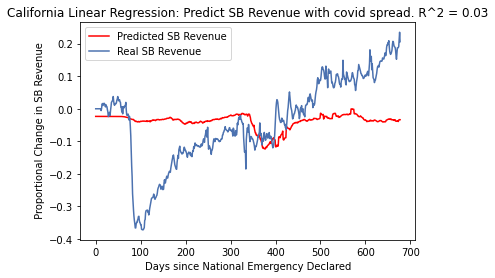

In [39]:
X_array, Y_var = prepare_data_linReg(covid,spending)
state = 'California'
reg = LinearRegression().fit(X_array,Y_var)
#print('R^2 for Ordinary Linear regression using Covid Spread features to predict all SB revenue is ', round(reg.score(X_array,Y_var),2))
Y_prediction = reg.predict(X_array)
linreg_r_squared =  round(reg.score(X_array,Y_var),2)
print(linreg_r_squared)
fig, ax = plot_linear_regression_on_state(Y_prediction, Y_var, state);


In [40]:
## WORK IN PROGRESS-

## WORK IN PROGRESS-
